In [ ]:
%%writefile Imagelib.h
#pragma once

#include <cstdint>
#include <cstdio>
#include <cstdlib>
#include <cstring>
#include <cassert>
#include <iostream>
#include <algorithm>
#include <fstream>
#include <string>
#include <vector>
#include <iomanip>

using byte = unsigned char;

#define LOG_OUT(_x_)
#define LOG_OUT_W(_x_)
#define LOG_OUT_A(_x_)

#pragma pack(push, 1)
struct BITMAPFILEHEADER {
    uint16_t bfType;
    uint32_t bfSize;
    uint16_t bfReserved1;
    uint16_t bfReserved2;
    uint32_t bfOffBits;
};

struct BITMAPINFOHEADER {
    uint32_t biSize;
    int32_t  biWidth;
    int32_t  biHeight;
    uint16_t biPlanes;
    uint16_t biBitCount;
    uint32_t biCompression;
    uint32_t biSizeImage;
    int32_t  biXPelsPerMeter;
    int32_t  biYPelsPerMeter;
    uint32_t biClrUsed;
    uint32_t biClrImportant;
};
#pragma pack(pop)

static inline uint32_t row_stride_24(int w) {
    return (uint32_t)(((w * 3) + 3) & ~3u);
}

// ---- 선언 ----
bool LoadBmp(const char* filename, byte** pImage, int& height, int& width);
bool SaveBmp(const char* filename, byte* pImage, int height, int width);
bool convert1Dto2D(byte* src, double** dst_Y, double** dst_U, double** dst_V, int height, int width);
bool convert2Dto1D(double** src_Y, double** src_U, double** src_V, byte* dst, int height, int width);

void convert2Dto3D(double **src2D, double ***dst3D, int height, int width);
void convert3Dto2D(double ***src3D, double **dst2D, int height, int width);

double *dmatrix1D(int nH);
double **dmatrix2D(int nH, int nW);
double ***dmatrix3D(int nH, int nW, int nC);
double ****dmatrix4D(int nH, int nW, int nC, int nNum);

void free_dmatrix1D(double *Image, int nH);
void free_dmatrix2D(double **Image, int nH, int nW);
void free_dmatrix3D(double ***Image, int nH, int nW, int nC);
void free_dmatrix4D(double ****Image, int nH, int nW, int nC, int nNum);

double clip(double x, double minVal, double maxVal);
double** simpleUpsampling2x(double **Image, int nH, int nW);

// ---- 정의 ----
bool LoadBmp(const char* filename, byte** pImage, int& height, int& width) {
    *pImage = nullptr;
    std::FILE* fp = std::fopen(filename, "rb");
    if (!fp) { LOG_OUT_A("fopen() error"); return false; }

    BITMAPFILEHEADER bmf{};
    BITMAPINFOHEADER bmi{};

    if (std::fread(&bmf, sizeof(bmf), 1, fp) != 1) { std::fclose(fp); return false; }
    if (bmf.bfType != 0x4D42) { std::fclose(fp); LOG_OUT_A("not .bmp file"); return false; }

    if (std::fread(&bmi, sizeof(bmi), 1, fp) != 1) { std::fclose(fp); return false; }
    if (bmi.biBitCount != 24 || bmi.biCompression != 0 /*BI_RGB*/) {
        std::fclose(fp); LOG_OUT_A("only 24-bit BI_RGB supported"); return false;
    }

    width  = bmi.biWidth;
    height = (bmi.biHeight >= 0) ? bmi.biHeight : -bmi.biHeight;
    const bool bottom_up = (bmi.biHeight > 0);

    const uint32_t stride = row_stride_24(width);
    const uint32_t data_bytes = stride * (uint32_t)height;

    // 픽셀 데이터 위치로 이동
    if (bmf.bfOffBits > sizeof(bmf) + sizeof(bmi)) {
        std::fseek(fp, (long)bmf.bfOffBits, SEEK_SET);
    }

    // 원본(패딩 포함) 읽기
    std::vector<unsigned char> buf(data_bytes);
    if (std::fread(buf.data(), 1, data_bytes, fp) != data_bytes) { std::fclose(fp); return false; }
    std::fclose(fp);

    // 호출자용 포맷: 패딩 없음, top→bottom, BGR 연속 메모리
    *pImage = (byte*)std::malloc((size_t)width * height * 3);
    if (!*pImage) return false;

    for (int y = 0; y < height; ++y) {
        int src_y = bottom_up ? (height - 1 - y) : y;
        const unsigned char* src = buf.data() + (size_t)src_y * stride;
        byte* dst = *pImage + (size_t)y * width * 3;
        std::memcpy(dst, src, (size_t)width * 3);
    }
    return true;
}

bool SaveBmp(const char* filename, byte* pImage, int height, int width) {
    // pImage: top→bottom, 패딩 없음, BGR 연속
    const uint32_t stride = row_stride_24(width);
    const uint32_t data_bytes = stride * (uint32_t)height;

    BITMAPFILEHEADER bmf{};
    BITMAPINFOHEADER bmi{};

    bmi.biSize = sizeof(BITMAPINFOHEADER);
    bmi.biWidth = width;
    bmi.biHeight = height;        // bottom-up 저장(양수)
    bmi.biPlanes = 1;
    bmi.biBitCount = 24;
    bmi.biCompression = 0;        // BI_RGB
    bmi.biSizeImage = data_bytes;

    bmf.bfType = 0x4D42; // 'BM'
    bmf.bfOffBits = sizeof(BITMAPFILEHEADER) + sizeof(BITMAPINFOHEADER);
    bmf.bfSize = bmf.bfOffBits + data_bytes;

    std::FILE* fp = std::fopen(filename, "wb");
    if (!fp) { LOG_OUT_A("fopen() error"); return false; }

    std::fwrite(&bmf, 1, sizeof(bmf), fp);
    std::fwrite(&bmi, 1, sizeof(bmi), fp);

    std::vector<unsigned char> row(stride, 0);
    for (int y = height - 1; y >= 0; --y) {
        const byte* src = pImage + (size_t)y * width * 3;
        std::memcpy(row.data(), src, (size_t)width * 3);
        std::fwrite(row.data(), 1, stride, fp);
    }
    std::fclose(fp);
    return true;
}

bool convert1Dto2D(byte* src, double** dst_Y, double** dst_U, double** dst_V, int height, int width) {
    int iR, iG, iB;
    for (int y = 0; y < height; y++) {
        for (int x = 0; x < width; x++) {
            iB = src[3 * width * y + 3 * x + 0];
            iG = src[3 * width * y + 3 * x + 1];
            iR = src[3 * width * y + 3 * x + 2];

            dst_Y[y][x] = iR * 0.299 + iG * 0.587 + iB * 0.114;
            dst_U[y][x] = (iB - dst_Y[y][x]) * 0.565;
            dst_V[y][x] = (iR - dst_Y[y][x]) * 0.713;

            dst_Y[y][x] = dst_Y[y][x] / 255.0; // [0,255] → [0,1]
        }
    }
    return true;
}

bool convert2Dto1D(double** src_Y, double** src_U, double** src_V, byte* dst, int height, int width) {
    int iCount = 0;
    int iR, iG, iB;
    for (int y = 0; y < height; y++) {
        for (int x = 0; x < width; x++) {
            double Y = src_Y[y][x] * 255.0;
            iR = (int)clip(Y + 1.403 * src_V[y][x], 0, 255);
            iG = (int)clip(Y - 0.344 * src_U[y][x] - 0.714 * src_V[y][x], 0, 255);
            iB = (int)clip(Y + 1.770 * src_U[y][x], 0, 255);

            dst[iCount + 0] = (byte)iB;
            dst[iCount + 1] = (byte)iG;
            dst[iCount + 2] = (byte)iR;
            iCount += 3;
        }
    }
    return true;
}

double clip(double x, double minVal, double maxVal) {
    if (x < minVal) x = minVal;
    if (x > maxVal) x = maxVal;
    return x;
}

double** simpleUpsampling2x(double **Image, int nH, int nW) {
    double** outImg = dmatrix2D(nH * 2, nW * 2);
    for (int y = 0; y < nH; y++) {
        for (int x = 0; x < nW; x++) {
            outImg[2 * y + 0][2 * x + 0] = Image[y][x];
            outImg[2 * y + 0][2 * x + 1] = Image[y][x];
            outImg[2 * y + 1][2 * x + 0] = Image[y][x];
            outImg[2 * y + 1][2 * x + 1] = Image[y][x];
        }
    }
    return outImg;
}

double *dmatrix1D(int nH) {
    return new double[nH]();
}

double **dmatrix2D(int nH, int nW) {
    double **Temp = new double*[nH];
    for (int y = 0; y < nH; y++) Temp[y] = new double[nW]();
    return Temp;
}

double ***dmatrix3D(int nH, int nW, int nC) {
    double ***Temp = new double**[nH];
    for (int y = 0; y < nH; y++) {
        Temp[y] = new double*[nW];
        for (int x = 0; x < nW; x++) Temp[y][x] = new double[nC]();
    }
    return Temp;
}

double ****dmatrix4D(int nH, int nW, int nC, int nNum) {
    double ****Temp = new double***[nH];
    for (int y = 0; y < nH; y++) {
        Temp[y] = new double**[nW];
        for (int x = 0; x < nW; x++) {
            Temp[y][x] = new double*[nC];
            for (int c = 0; c < nC; c++) Temp[y][x][c] = new double[nNum]();
        }
    }
    return Temp;
}

void free_dmatrix1D(double *Image, int) { delete[] Image; }

void free_dmatrix2D(double **Image, int nH, int) {
    for (int y = 0; y < nH; y++) delete[] Image[y];
    delete[] Image;
}

void free_dmatrix3D(double ***Image, int nH, int nW, int) {
    for (int y = 0; y < nH; y++) {
        for (int x = 0; x < nW; x++) delete[] Image[y][x];
        delete[] Image[y];
    }
    delete[] Image;
}

void free_dmatrix4D(double ****Image, int nH, int nW, int nC, int) {
    for (int y = 0; y < nH; y++) {
        for (int x = 0; x < nW; x++) {
            for (int c = 0; c < nC; c++) delete[] Image[y][x][c];
            delete[] Image[y][x];
        }
        delete[] Image[y];
    }
    delete[] Image;
}

void convert2Dto3D(double **src2D, double ***dst3D, int height, int width) {
    for (int y = 0; y < height; y++)
        for (int x = 0; x < width; x++)
            dst3D[y][x][0] = src2D[y][x];
}

void convert3Dto2D(double ***src3D, double **dst2D, int height, int width) {
    for (int y = 0; y < height; y++)
        for (int x = 0; x < width; x++)
            dst2D[y][x] = src3D[y][x][0];
}


Writing Imagelib.h


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving baby_512x512_input.bmp to baby_512x512_input.bmp


In [ ]:
%%writefile CTensor.h

#pragma once
#include "Imagelib.h"
#include <iostream>

class Tensor3D {
private:
    double*** tensor;
    int nH; // height
    int nW; // width
    int nC; // channel

public:

    Tensor3D(int _nH, int _nW, int _nC) : tensor(nullptr), nH(_nH), nW(_nW), nC(_nC) {
        tensor = dmatrix3D(nH, nW, nC);
        for (int h = 0; h < nH; ++h) {
            for (int w = 0; w < nW; ++w) {
                for (int c = 0; c < nC; ++c) {
                    tensor[h][w][c] = 0.0;
                }
            }
        }
    }

    ~Tensor3D() {
        if (tensor) {
            free_dmatrix3D(tensor, nH, nW, nC);
            tensor = nullptr;
        }
    }

    inline void set_elem(int _h, int _w, int _c, double _val) { tensor[_h][_w][_c] = _val; }

    inline double get_elem(int _h, int _w, int _c) const {
        return tensor[_h][_w][_c];
    }


    inline void get_info(int& _nH, int& _nW, int& _nC) const {
        _nH = nH; _nW = nW; _nC = nC;
    }

    inline void set_tensor(double*** _tensor) { tensor = _tensor; }
    inline double*** get_tensor() const { return tensor; }

    void print() const {
        std::cout << "Tensor3D size: "
                  << nH << " x " << nW << " x " << nC
                  << " (" << static_cast<long long>(nH) * nW * nC << " elements)"
                  << std::endl;
    }
};

Writing CTensor.h


In [ ]:
%%writefile CLayer.h
#pragma once
#include <iostream>
#include <fstream>
#include <stdexcept>
#include <string>
#include <omp.h>
#include "Imagelib.h"
#include "CTensor.h"

#define MEAN_INIT 0
#define LOAD_INIT 1

using std::cout;
using std::endl;
using std::string;

class Layer {
protected:
    int fK;
    int fC_in;
    int fC_out;
    string name;
public:
    Layer(string _name, int _fK, int _fC_in, int _fC_out)
        : name(_name), fK(_fK), fC_in(_fC_in), fC_out(_fC_out) {}
    virtual ~Layer() {}
    virtual Tensor3D* forward(const Tensor3D* input) = 0;
    virtual void print() const = 0;
    virtual void get_info(string& _name, int& _fK, int& _fC_in, int& _fC_out) const = 0;
};

class Layer_ReLU : public Layer {
public:
    Layer_ReLU(string _name, int _fK, int _fC_in, int _fC_out)
        : Layer(_name, _fK, _fC_in, _fC_out) {}
    ~Layer_ReLU() {}

    Tensor3D* forward(const Tensor3D* input) override {
        int nH, nW, nC;
        input->get_info(nH, nW, nC);
        Tensor3D* output = new Tensor3D(nH, nW, nC);

        #pragma omp parallel for collapse(3) schedule(static)
        for (int h = 0; h < nH; ++h)
            for (int w = 0; w < nW; ++w)
                for (int c = 0; c < nC; ++c) {
                    double x = input->get_elem(h, w, c);
                    output->set_elem(h, w, c, x > 0.0 ? x : 0.0);
                }

        cout << name << " is finished" << endl;
        return output;
    }

    void get_info(string& _name, int& _fK, int& _fC_in, int& _fC_out) const override {
        _name = name; _fK = fK; _fC_in = fC_in; _fC_out = fC_out;
    }

    void print() const override {
        cout << "[Layer_ReLU] " << name
             << " | fK=" << fK
             << " | C_in=" << fC_in
             << " | C_out=" << fC_out
             << endl;
    }
};

class Layer_Conv : public Layer {
private:
    string filename_weight;
    string filename_bias;
    double**** weight_tensor; // [fK][fK][fC_in][fC_out]
    double*   bias_tensor;    // [fC_out]

    void init(int init_type) {
        weight_tensor = dmatrix4D(fK, fK, fC_in, fC_out);
        bias_tensor   = dmatrix1D(fC_out);

        if (init_type == MEAN_INIT) {
            const double val = 1.0 / static_cast<double>(fK * fK * fC_in);
            for (int kh=0; kh<fK; ++kh)
                for (int kw=0; kw<fK; ++kw)
                    for (int ic=0; ic<fC_in; ++ic)
                        for (int oc=0; oc<fC_out; ++oc)
                            weight_tensor[kh][kw][ic][oc] = val;
            for (int oc=0; oc<fC_out; ++oc) bias_tensor[oc] = 0.0;
        } else if (init_type == LOAD_INIT) {
            if (filename_weight.empty() || filename_bias.empty())
                throw std::runtime_error("LOAD_INIT requires valid weight/bias filenames.");

            std::ifstream fw(filename_weight);
            if (!fw.is_open()) throw std::runtime_error("Failed to open weight file: " + filename_weight);
            for (int kh=0; kh<fK; ++kh)
                for (int kw=0; kw<fK; ++kw)
                    for (int ic=0; ic<fC_in; ++ic)
                        for (int oc=0; oc<fC_out; ++oc) {
                            double v;
                            if (!(fw >> v)) throw std::runtime_error("Invalid weight data in " + filename_weight);
                            weight_tensor[kh][kw][ic][oc] = v;
                        }
            fw.close();

            std::ifstream fb(filename_bias);
            if (!fb.is_open()) throw std::runtime_error("Failed to open bias file: " + filename_bias);
            for (int oc=0; oc<fC_out; ++oc) {
                double b;
                if (!(fb >> b)) throw std::runtime_error("Invalid bias data in " + filename_bias);
                bias_tensor[oc] = b;
            }
            fb.close();
        } else {
            throw std::runtime_error("Unknown init_type for Layer_Conv");
        }
    }

public:
    Layer_Conv(string _name, int _fK, int _fC_in, int _fC_out, int init_type,
               string _filename_weight = "", string _filename_bias = "")
        : Layer(_name, _fK, _fC_in, _fC_out),
          filename_weight(_filename_weight),
          filename_bias(_filename_bias),
          weight_tensor(nullptr),
          bias_tensor(nullptr)
    {
        init(init_type);
    }

    ~Layer_Conv() override {
        if (weight_tensor) { free_dmatrix4D(weight_tensor, fK, fK, fC_in, fC_out); weight_tensor = nullptr; }
        if (bias_tensor)   { free_dmatrix1D(bias_tensor, fC_out); bias_tensor = nullptr; }
    }

    Tensor3D* forward(const Tensor3D* input) override {
        int inH, inW, inC;
        input->get_info(inH, inW, inC);
        if (inC != fC_in) throw std::runtime_error("Conv: input channel mismatch.");

        const int pad = fK / 2;      // SAME padding
        const int outH = inH;
        const int outW = inW;
        Tensor3D* output = new Tensor3D(outH, outW, fC_out);

        #pragma omp parallel for collapse(3) schedule(static)
        for (int h=0; h<outH; ++h){
            for (int w=0; w<outW; ++w){
                for (int oc=0; oc<fC_out; ++oc){
                    double acc = bias_tensor[oc];
                    for (int kh=0; kh<fK; ++kh){
                        for (int kw=0; kw<fK; ++kw){
                            for (int ic=0; ic<fC_in; ++ic){
                                int ih = h + kh - pad;
                                int iw = w + kw - pad;
                                if (ih < 0 || iw < 0 || ih >= inH || iw >= inW) continue; // zero-pad
                                double x = input->get_elem(ih, iw, ic);
                                acc += weight_tensor[kh][kw][ic][oc] * x;
                            }
                        }
                    }
                    output->set_elem(h, w, oc, acc);
                }
            }
        }
        cout << name << " is finished" << endl;
        return output;
    }

    void get_info(string& _name, int& _fK, int& _fC_in, int& _fC_out) const override {
        _name = name; _fK = fK; _fC_in = fC_in; _fC_out = fC_out;
    }

    void print() const override {
        cout << "[Layer_Conv] " << name
             << " | fK=" << fK
             << " | C_in=" << fC_in
             << " | C_out=" << fC_out
             << " | stride=1, padding=SAME" << endl;
    }
};

Writing CLayer.h


In [ ]:
%%writefile CModel.h
#pragma once
#include <vector>
#include <string>
#include <iostream>
#include <iomanip>
#include "CLayer.h"

using std::vector;
using std::string;
using std::cout;
using std::endl;
using std::setw;

class Model {
private:
    vector<Layer*> layers;
    vector<Tensor3D*> tensors;

public:
    Model() {}

    void add_layer(Layer* layer) { layers.push_back(layer); }

    ~Model() {
        for (auto* t : tensors) delete t;
        tensors.clear();
        for (auto* l : layers) delete l;
        layers.clear();
    }

    void test(string filename_input, string filename_output) {
        int nH, nW;
        double **input_img_Y, **input_img_U, **input_img_V;
        byte* pLoadImage;

        read_image(filename_input, pLoadImage, input_img_Y, input_img_U, input_img_V, nH, nW);
        cout << "Reading (" << filename_input << ") is complete..." << endl;

        for (size_t i = 0; i < layers.size(); ++i) {
            Tensor3D* in  = tensors.at(i);
            Tensor3D* out = layers.at(i)->forward(in);
            tensors.push_back(out);
        }
        cout << "Super-resolution is complete..." << endl;

        Tensor3D* output_tensor_Y = tensors.back();
        save_image(filename_output, pLoadImage, output_tensor_Y, input_img_U, input_img_V, nH, nW);
        cout << "Saving (" << filename_output << ") is complete..." << endl;

        free(pLoadImage);
        free_dmatrix2D(input_img_Y, nH, nW);
        free_dmatrix2D(input_img_U, nH, nW);
        free_dmatrix2D(input_img_V, nH, nW);
    }

    void read_image(const string filename, byte*& pLoadImage,
                    double**& img_Y, double**& img_U, double**& img_V,
                    int& nH, int& nW) {
        LoadBmp(filename.c_str(), &pLoadImage, nH, nW);

        img_Y = dmatrix2D(nH, nW);
        img_U = dmatrix2D(nH, nW);
        img_V = dmatrix2D(nH, nW);

        convert1Dto2D(pLoadImage, img_Y, img_U, img_V, nH, nW);

        double*** inImage3D = dmatrix3D(nH, nW, 1);
        convert2Dto3D(img_Y, inImage3D, nH, nW);

        Tensor3D* temp = new Tensor3D(nH, nW, 1);
        temp->set_tensor(inImage3D);
        tensors.push_back(temp);
    }

    void save_image(string filename, byte*& pLoadImage, Tensor3D*& tensor_Y,
                    double** img_U, double** img_V, int nH, int nW) {
        double** img_Y = dmatrix2D(nH, nW);
        convert3Dto2D(tensor_Y->get_tensor(), img_Y, nH, nW);
        convert2Dto1D(img_Y, img_U, img_V, pLoadImage, nH, nW);
        SaveBmp(filename.c_str(), pLoadImage, nH, nW);
        free_dmatrix2D(img_Y, nH, nW);
    }

    void print_layer_info() const {
        cout << "\n(Layer information)\n"
             << "-----------------------------\n";
        for (unsigned i = 0; i < layers.size(); ++i) {
            std::string name; int k, cin_, cout_;
            layers[i]->get_info(name, k, cin_, cout_);
            cout << (i + 1) << "-th layer: "
                 << std::left << setw(8) << (name + ":")
                 << k << "*" << k << "*" << cin_ << "*" << cout_ << "\n";
        }
    }

    void print_tensor_info() const {
        cout << "\n(Tensor information)\n"
             << "-----------------------------\n";
        for (unsigned i = 0; i < tensors.size(); ++i) {
            int H, W, C;
            tensors[i]->get_info(H, W, C);
            cout << (i + 1) << "-th tensor: "
                 << H << "*" << W << "*" << C << "\n";
        }
    }
};

Writing CModel.h


In [ ]:
%%writefile main.cpp
#include "Imagelib.h"
#include "CModel.h"
#include "CTensor.h"
#include <chrono>
#include <cstdio>
#include <cstdlib>
#include <fstream>
#include <iostream>
#include <sstream>
#ifdef _OPENMP
#include <omp.h>
#endif
using namespace std;

static string read_cpu_model() {
    ifstream cpuinfo("/proc/cpuinfo");
    string line;
    while (getline(cpuinfo, line)) {
        auto pos = line.find("model name");
        if (pos != string::npos) {
            auto col = line.find(':', pos);
            if (col != string::npos) {
                string v = line.substr(col + 1);
                while (!v.empty() && (v.front()==' '||v.front()=='\t')) v.erase(v.begin());
                return v;
            }
        }
    }
    return "Unknown CPU";
}

static long read_mem_total_mb() {
    ifstream meminfo("/proc/meminfo");
    string key, unit;
    long kb=0;
    while (meminfo >> key >> kb >> unit) {
        if (key == "MemTotal:") return kb/1024;
        string rest; getline(meminfo, rest);
    }
    return 0;
}

static string try_nvidia_smi() {

    const char* cmd =
        "nvidia-smi --query-gpu=name,driver_version,memory.total "
        "--format=csv,noheader 2>/dev/null";
    FILE* pipe = popen(cmd, "r");
    if (!pipe) return "";
    char buf[512];
    string out;
    while (fgets(buf, sizeof(buf), pipe)) out += buf;
    pclose(pipe);
    while (!out.empty() && (out.back()=='\n'||out.back()=='\r')) out.pop_back();
    return out;
}

static void print_hardware_info() {
    cout << "===== Hardware Info =====" << endl;
    cout << "CPU   : " << read_cpu_model() << endl;
    long mem_mb = read_mem_total_mb();
    if (mem_mb > 0) cout << "Memory: " << mem_mb << " MB" << endl;

#ifdef _OPENMP
    cout << "OpenMP: yes" << endl;
    cout << "  omp_get_max_threads(): " << omp_get_max_threads() << endl;
    cout << "  omp_get_num_procs()  : " << omp_get_num_procs()   << endl;
#else
    cout << "OpenMP: no (compile with -fopenmp)" << endl;
#endif

    string gpu = try_nvidia_smi();
    if (!gpu.empty()) cout << "GPU   : " << gpu << endl;
    else              cout << "GPU   : (no NVIDIA GPU detected or nvidia-smi unavailable)" << endl;
}

static void bench_tensor_ops() {
    const int H = 1024, W = 2048, C = 16;
    Tensor3D t(H, W, C);

    auto now = [](){ return chrono::high_resolution_clock::now(); };
    auto ms  = [](auto dt){ return chrono::duration<double, std::milli>(dt).count(); };

    auto t0 = now();
    for (int h = 0; h < H; ++h)
        for (int w = 0; w < W; ++w)
            for (int c = 0; c < C; ++c)
                t.set_elem(h, w, c, (h*0.1 + w*0.2 + c*0.3));
    auto t1 = now();
    double fill_serial_ms = ms(t1 - t0);

    t0 = now();
    double s_serial = 0.0;
    for (int h = 0; h < H; ++h)
        for (int w = 0; w < W; ++w)
            for (int c = 0; c < C; ++c)
                s_serial += t.get_elem(h, w, c);
    t1 = now();
    double sum_serial_ms = ms(t1 - t0);

    t0 = now();
    #pragma omp parallel for collapse(3) schedule(static)
    for (int h = 0; h < H; ++h)
        for (int w = 0; w < W; ++w)
            for (int c = 0; c < C; ++c)
                t.set_elem(h, w, c, (h*0.1 + w*0.2 + c*0.3));
    t1 = now();
    double fill_parallel_ms = ms(t1 - t0);

    t0 = now();
    double s_parallel = 0.0;
    #pragma omp parallel for collapse(3) reduction(+:s_parallel) schedule(static)
    for (int h = 0; h < H; ++h)
        for (int w = 0; w < W; ++w)
            for (int c = 0; c < C; ++c)
                s_parallel += t.get_elem(h, w, c);
    t1 = now();
    double sum_parallel_ms = ms(t1 - t0);

    double total_serial   = fill_serial_ms   + sum_serial_ms;
    double total_parallel = fill_parallel_ms + sum_parallel_ms;

    printf("===== Benchmark Tensor =====\n");
    printf("Size: %d x %d x %d\n", H, W, C);
    printf("Serial  : fill %.3f ms, sum %.3f ms, total %.3f ms\n",
           fill_serial_ms, sum_serial_ms, total_serial);
    printf("Parallel: fill %.3f ms, sum %.3f ms, total %.3f ms\n",
           fill_parallel_ms, sum_parallel_ms, total_parallel);
    printf("sum(serial) = %.6f, sum(parallel) = %.6f\n", s_serial, s_parallel);
    printf("Speedup (Serial/Parallel): %.3fx\n",
           (total_parallel > 0 ? total_serial / total_parallel : 0.0));
}

int main() {
#ifdef _OPENMP
    if (getenv("OMP_NUM_THREADS") == nullptr) omp_set_num_threads(8);
#endif

    Model model;
    model.add_layer(new Layer_Conv("Conv1", 3, 1, 1, MEAN_INIT));
    model.add_layer(new Layer_ReLU("Relu1", 1, 1, 1));
    model.add_layer(new Layer_Conv("Conv2", 3, 1, 1, MEAN_INIT));
    model.add_layer(new Layer_ReLU("Relu2", 1, 1, 1));
    model.add_layer(new Layer_Conv("Conv3", 3, 1, 1, MEAN_INIT));

    model.test("baby_512x512_input.bmp", "baby_512x512_output_mean.bmp");
    model.print_layer_info();
    model.print_tensor_info();

    bench_tensor_ops();
		print_hardware_info();
    return 0;
}

Overwriting main.cpp


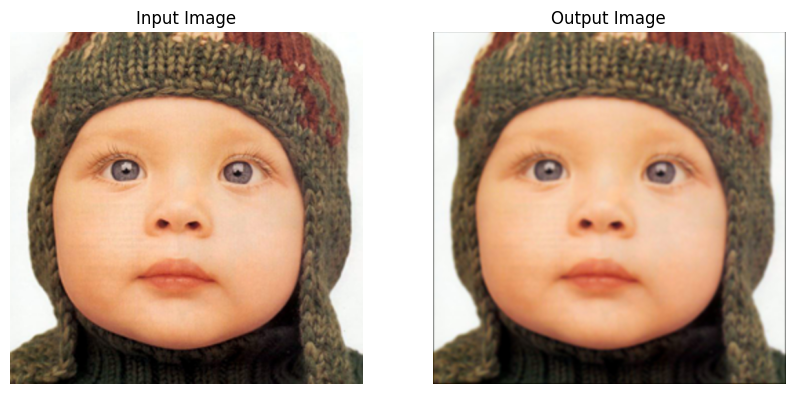

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

in_path  = "baby_512x512_input.bmp"
out_path = "baby_512x512_output_mean.bmp"

img_in  = Image.open(in_path)
img_out = Image.open(out_path)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img_in)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Output Image")
plt.imshow(img_out)
plt.axis("off")

plt.show()

In [ ]:
!g++ -std=c++17 -O2 -fopenmp \
  main.cpp CModel.h CLayer.h CTensor.h Imagelib.h \
  -o run
!./run

CModel.h:1:9: warning: #pragma once in main file
    1 | #pragma once
      |         ^~~~
CLayer.h:1:9: warning: #pragma once in main file
    1 | #pragma once
      |         ^~~~
CTensor.h:2:9: warning: #pragma once in main file
    2 | #pragma once
      |         ^~~~
Imagelib.h:1:9: warning: #pragma once in main file
    1 | #pragma once
      |         ^~~~
Reading (baby_512x512_input.bmp) is complete...
Conv1 is finished
Relu1 is finished
Conv2 is finished
Relu2 is finished
Conv3 is finished
Super-resolution is complete...
Saving (baby_512x512_output_mean.bmp) is complete...

(Layer information)
-----------------------------
1-th layer: Conv1:  3*3*1*1
2-th layer: Relu1:  1*1*1*1
3-th layer: Conv2:  3*3*1*1
4-th layer: Relu2:  1*1*1*1
5-th layer: Conv3:  3*3*1*1

(Tensor information)
-----------------------------
1-th tensor: 512*512*1
2-th tensor: 512*512*1
3-th tensor: 512*512*1
4-th tensor: 512*512*1
5-th tensor: 512*512*1
6-th tensor: 512*512*1
===== Benchmark Tensor =====
